# Figures

This notebook creates the following figures:

* visual field coverage plots
* polar angle histograms
* eccentricity distributions
* eccentricity-size relations
* timeseries plot
* across-split correlation of parameters
* tSNR - R2 correlations

In [1]:
# imports
from __future__ import division
import os
import nibabel as nb
import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import glob
import statsmodels.api as sm
import statsmodels.stats.api as sms
from tqdm import tqdm


import pandas as pd
import shutil
import pycircstat as pc

import matplotlib as mpl
%matplotlib inline
mpl.rc_file_defaults()

### define directories:

In [2]:
# set this to your data directory:
data_dir = '/home/shared/2018/visual/hcp_cerebellum/'
repo_dir = '/home/vanes/git/hcp_cerebellum/'

### subdirectories

In [3]:
resource_dir = os.path.join(repo_dir,'resources')
retmap_dir = os.path.join(resource_dir,'volume_masks')

# setup figure directory
fig_dir = os.path.join(data_dir,'figs')
if not os.path.isdir(fig_dir): os.mkdir(fig_dir)

### settings

In [4]:
# these are the dimensions of the niftis
dims = {
    'ang':0,
    'ecc':1,
    'gain':2,
    'meanvol':3,
    'r2':4,
    'rfsize':5
}   

stim_radius = 8
avg_masktype = 'r2_spill_fix'
ind_masktype = 'r2_fix_roi'

### define rois

In [5]:
# these refer to the indices in cerebellum_retmaps.nii
mask_names ={
'left_mOMV':7,
'right_mOMV':9,
'left_lOMV':8,
'right_lOMV':10,
    
'left_VIIb':5,
'right_VIIb':6,
    
'left_mVIIIb':3,
'right_mVIIIb':2,
'left_lVIIIb':4,
'right_lVIIIb':1,
}

# this is how the lateral/medial and left right hemisphere indices combine:
roi_combs = {
    'left_OMV':[7,8],
    'right_OMV':[9,10],
    'left_VIIb':[5],
    'right_VIIb':[6],
    'left_VIIIb':[3,4],
    'right_VIIIb':[1,2],

    'OMV':[7,8,9,10],
    'lOMV':[8,10],
    'mOMV':[7,9],
    'VIIb':[5,6],
    'VIIIb':[1,2,3,4],
    'lVIIIb':[1,4],
    'mVIIIb':[2,3],
    
    'all_rois':[1,2,3,4,5,6,7,8,9,10]
}

roi_order = ['left_mOMV','right_mOMV','left_lOMV','right_lOMV','left_VIIb','right_VIIb','left_mVIIIb','right_mVIIIb','left_lVIIIb','right_lVIIIb']
roi_comb_order = ['mOMV','lOMV','VIIb','mVIIIb','lVIIIb']           

#### load data

In [6]:
# get the data
sjs = range(181) + ['181','181_1','181_2','182','182_1','182_2','183','183_1','183_2']
data = {}
for sj in sjs:
    if sj == '183':
        data[sj] =nb.load(os.path.join(data_dir,'masked_niftis',avg_masktype,'prfresults_subject_rank_%s.nii.gz'%sj)).get_data() 
    else:
        data[sj] =nb.load(os.path.join(data_dir,'masked_niftis',ind_masktype,'prfresults_subject_rank_%s.nii.gz'%sj)).get_data() 
    
cer_retmaps = nb.load(os.path.join(retmap_dir,'cerebellum_retmaps.nii')).get_data()
cer_mask = nb.load(os.path.join(retmap_dir,'cmask.nii')).get_data()

#### function for determining roi color

In [7]:
def get_roi_color(mask):
    
    # determine base roi colors
    if mask in ['left_OMV','right_OMV','OMV']:
        c = '#6590CB'
    elif mask in ['left_VIIIb','right_VIIIb','VIIIb']:
        c = '#E55D5C'
    elif ('VIIb' in mask) + (mask=='VIIb'):
        c = '#E79F2A'
        
    # roi colors for lateral / medial separation:
    elif mask in ['left_lOMV','right_lOMV','lOMV']:
        c = '#6590CB'
    elif mask in ['left_mOMV','right_mOMV','mOMV']:
        c = '#0D5B99'
    elif mask in ['left_mVIIIb','right_mVIIIb','mVIIIb']:
        c = '#C03142'
    elif mask in ['left_lVIIIb','right_lVIIIb','lVIIIb']:
        c = '#E57F80'
        
    # for all rois and masks
    elif mask in ['all_rois']:
        c = 'k'
    elif mask in ['all_voxels']:
        c = 'gray'
        
    return c

### visualize pRF center + size distribution

In [62]:
for sj in ['181','182','183','183_1','183_2']:
    avgdata = data[sj]
    f = pl.figure(figsize=(2,4.5))
    for mi,mask in enumerate(roi_order):

        s = f.add_subplot(5,2,mi+1,aspect='equal')

        # determine this roi mask
        roimask = (cer_retmaps==(mask_names[mask]))

        # convert polar to cartesian:
        xs = np.cos(np.radians(np.ravel(avgdata[roimask,dims['ang']]))) * np.ravel(avgdata[roimask,dims['ecc']])
        ys = np.sin(np.radians(np.ravel(avgdata[roimask,dims['ang']]))) * np.ravel(avgdata[roimask,dims['ecc']])
        eccs = np.ravel(avgdata[roimask,dims['ecc']])

        # get sizes
        sizes = np.ravel(avgdata[roimask,dims['rfsize']])
        
        # generate mask
        v = ~np.isnan(sizes)
        v *= (eccs < stim_radius)
        
        # apply mask
        xs = xs[v]
        ys = ys[v]
        sizes = sizes[v]

        # determine roi color
        c = get_roi_color(mask)

        # now draw a circle at rf size
        for x,y,sigma in zip(xs,ys,sizes):
            s.add_artist(pl.Circle((x,y),sigma, color=c,fill=False,alpha=0.25))

        # draw crosshair
        pl.axhline(0,lw=0.5,color='k')
        pl.axvline(0,lw=0.5,color='k')

        # draw dot at center 
        pl.plot(xs,ys,'o',color=c,ms=3,mec='w',mew=1,alpha=1)
        pl.xlim(-stim_radius,stim_radius)
        pl.ylim(-stim_radius,stim_radius)   

        # only draw the axis labels for VIIIb:
        if mask =='left_lVIIIb':
            pl.xticks([-stim_radius,0,stim_radius],['-%d'%stim_radius,0,'%.d'%stim_radius])
            pl.yticks([-stim_radius,0,stim_radius],['-%d'%stim_radius,0,'%.d'%stim_radius])
            sn.despine(offset=2)
        elif mask =='right_lVIIIb':
            pl.xticks([-stim_radius,0,stim_radius],['-%.d'%stim_radius,0,'%.d'%stim_radius])
            pl.yticks([])
            sn.despine(offset=2,left=True)
        else:
            pl.axis('off')
            pl.xticks([])
            pl.yticks([])                

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_scatter_avg_subject_%s.pdf'%sj))

### create eccentricity-size plot

In [63]:
for sj in ['181','182','183','183_1','183_2']:
    avgdata = data[sj]
    # eccen-size plot
    this_roi_comb_order = ['mVIIIb','lVIIIb','VIIb','mOMV','lOMV']

    f = pl.figure(figsize=(1.25,1.25))
    s = f.add_subplot(111)

    all_max_eccs = []
    all_max_sizes=[]
    for mi,mask in enumerate(this_roi_comb_order):

        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        # determine roi color
        c = get_roi_color(mask)  

        sizes = np.ravel(avgdata[roimask,dims['rfsize']])
        eccs = np.ravel(avgdata[roimask,dims['ecc']])

        maxecc = np.min([np.nanmax(eccs),stim_radius])
    
        # generate mask
        v = (eccs < maxecc)
        v*= ~np.isnan(sizes)

        # do linear regression with statsmodels
        y = sizes[v]
        X = eccs[v]
        X = sm.add_constant(X)     

        mod = sm.OLS(y, X)
        res = mod.fit()
        ci_intercept,ci_slope = res.conf_int(0.05)
        mean_intercept,mean_slope = res.params

        fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
        fit_high = np.polyval([ci_slope[0],ci_intercept[1]],np.linspace(0,maxecc,15))
        fit_low = np.polyval([ci_slope[1],ci_intercept[0]],np.linspace(0,maxecc,15))

        pl.plot(np.linspace(0,maxecc,15),fit,color=c,lw=2)
        pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.25,color=c)

    pl.xlim(0,stim_radius)  
    pl.ylim(0,10)
    pl.xticks([0,stim_radius])
    pl.yticks([0,10])

    sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_eccsize_avg_%s.pdf'%sj))

### create eccentricity histogram

In [70]:
for sj in ['181','182','183','183_1','183_2']:
    avgdata = data[sj]
    f = pl.figure(figsize=(1.25,2))
    s = f.add_subplot(111)

    dc = pd.DataFrame()
    colors = []

    for mi,mask in enumerate(roi_comb_order):

        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        # get data
        eccs = np.ravel(avgdata[roimask,dims['ecc']])
        
        v = ~np.isnan(eccs)
        
        eccs = eccs[v]

        # get roi color and append to all
        c = get_roi_color(mask)
        colors.append(c)

        # get eccentricities, append with nans (otherwise df is shortened to roi with least voxels)
        dc[mask] = np.hstack([eccs,np.ones(100000-len(eccs))*np.nan])

    sn.violinplot(data=dc,palette=colors,scale='width',orient='h',linewidth=0)

    pl.xlim(0,stim_radius)
    pl.xticks([0,stim_radius])
    sn.despine(offset=2)
    pl.xlabel('eccen (dva)')

    pl.tight_layout(pad=0)
    f.savefig(os.path.join(fig_dir,'ecc_histograms_avg_%s.pdf'%sj))

### polar histogram

In [74]:
for sj in ['181','182','183','183_1','183_2']:
    avgdata = data[sj]
    for hemi in ['left','right']:
        f = pl.figure(figsize=(0.75,4.5))

        for mi,roi in enumerate(['mOMV','lOMV','VIIb','mVIIIb','lVIIIb']):
            mask = hemi+'_'+roi
            s = f.add_subplot(5,1,mi+1,projection='polar')

            # determine this roi mask
            roimask = (cer_retmaps==(mask_names[mask]))

            # determine color for this ROI
            c = get_roi_color(mask)

            # get data (convert to radians for polar plot)
            angles = np.radians(np.ravel(avgdata[roimask,dims['ang']]))
            eccs = np.ravel(avgdata[roimask,dims['ecc']])

            v = ~np.isnan(angles)
            v *= (eccs < stim_radius)
            angles = angles[v]
            
            # compute bins (let's do for 12 bins)
            bins_number = 12
            bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
            n, _, _ = pl.hist(angles, bins)
            width = (2 * np.pi) / bins_number

            # plot polar bars
            s.cla()        
            pl.bar(bins[:bins_number], n, width=width, bottom=0.0,ec=c,color=c)

            # plot settings
            pl.xticks([])
            pl.yticks([])
            pl.ylim(0,np.max(n))

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'polar_histograms_avg_%s_%s.pdf'%(hemi,sj)))

### individual subject eccen-size relations - selected subjects

In [96]:
# eccen-size plot
for sgi,sjg in zip([range(5),range(88,93),range(176,181)],['top','mid','bottom']):
    
    roi_comb_order = ['mOMV','lOMV','VIIb','mVIIIb','lVIIIb']               


    f = pl.figure(figsize=(0.75*5,0.75))
    for mi,mask in enumerate(roi_comb_order):
        s = f.add_subplot(1,len(roi_comb_order),mi+1)

        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        # determine ecc limit and roi color
        c = get_roi_color(mask)  

        for sj in sgi:
            
            this_sj_data = nb.load(os.path.join(data_dir,'masked_niftis',ind_masktype,'prfresults_subject_rank_%d.nii.gz'%sj)).get_data()

            try:                
                sizes = np.ravel(this_sj_data[roimask,dims['rfsize']])
                eccs = np.ravel(this_sj_data[roimask,dims['ecc']])                
                
                maxecc = np.min([np.nanmax(eccs),stim_radius])

                # determine valid voxels
                v = (eccs < maxecc)
                v *= ~np.isnan(eccs)

                # do linear regression with statsmodels
                y = sizes[v]
                X = eccs[v]
                X = sm.add_constant(X)     

                mod = sm.OLS(y, X)
                res = mod.fit()
                ci_intercept,ci_slope = res.conf_int(0.05)
                mean_intercept,mean_slope = res.params


                fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
                fit_high = np.polyval([ci_slope[0],ci_intercept[1]],np.linspace(0,maxecc,15))
                fit_low = np.polyval([ci_slope[1],ci_intercept[0]],np.linspace(0,maxecc,15))

                pl.plot(np.linspace(0,maxecc,15),fit,color=c,lw=1)
                pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.25,color=c)
                
            except:
#                 print 'could not fit %s ecc-size relation for %s subject %d (too little data)'%(mask,sjg,sj)
                pass

        pl.xlim(0,stim_radius)  
        pl.ylim(0,10)
        pl.xticks([0,stim_radius])
        pl.yticks([0,10])

        sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_eccsize_all_%s.pdf'%(sjg)))

### individual subject eccen-size relations - all subjects

In [16]:
# eccen-size plot
this_roi_comb_order = ['mVIIIb','lVIIIb','VIIb','mOMV','lOMV']
min_vox_ns = [5,10,15]
for min_vox_n in min_vox_ns:
    f = pl.figure(figsize=(1.25,1.25))

    for mi,mask in enumerate(this_roi_comb_order):
    #     s = f.add_subplot(1,len(roi_comb_order),mi+1)

        s = f.add_subplot(1,1,1)

        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        # determine ecc limit and roi color
        c = get_roi_color(mask)  

        all_slopes = []
        all_intercepts = []
        maxeccs = []
        for sj in range(181):

            this_sj_data = nb.load(os.path.join(data_dir,'masked_niftis',ind_masktype,'prfresults_subject_rank_%d.nii.gz'%sj)).get_data()

            sizes = np.ravel(this_sj_data[roimask,dims['rfsize']])
            eccs = np.ravel(this_sj_data[roimask,dims['ecc']])                

            # mask voxels
            maxecc = np.min([np.nanmax(eccs),stim_radius])
            v = (eccs < maxecc)        
            v = ~np.isnan(sizes)

            # only go on if there are sufficient voxels in this subject
            if v.sum() > min_vox_n:

                maxeccs.append(maxecc)

                # do linear regression with statsmodels
                y = sizes[v]
                X = eccs[v]
                X = sm.add_constant(X)     

                mod = sm.OLS(y, X)
                res = mod.fit()
                intercept,slope = res.params

                all_slopes.append(slope)
                all_intercepts.append(intercept)

        maxecc = np.mean(maxeccs)

        print '%s, n subs: %d, maxecc: %.2f'%(mask,len(all_slopes),maxecc)

        # compute mean and ci across valid subjects
        mean_slope = np.mean(all_slopes)
        mean_intercept = np.mean(all_intercepts)

        ci_slope = sms.DescrStatsW(data=np.array(all_slopes)).tconfint_mean()
        ci_intercept = sms.DescrStatsW(data=np.array(all_intercepts)).tconfint_mean()
    
        print 'slope: %.2f, %.2f-%.2f'%(mean_slope,ci_slope[0],ci_slope[1])
        print 'intercept: %.2f, %.2f-%.2f'%(mean_intercept,ci_intercept[0],ci_intercept[1])

        fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
        fit_high = np.polyval([ci_slope[0],ci_intercept[1]],np.linspace(0,maxecc,15))
        fit_low = np.polyval([ci_slope[1],ci_intercept[0]],np.linspace(0,maxecc,15))

        pl.plot(np.linspace(0,maxecc,15),fit,color=c,lw=1)
        pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.25,color=c)

    pl.xlim(0,stim_radius)  
    pl.ylim(0,10)
    pl.xticks([0,stim_radius])
    pl.yticks([0,10])

    sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_eccsize_all_subjects_min_voxn_%d.pdf'%min_vox_n))

mVIIIb, n subs: 125, maxecc: 6.44
slope: 0.81, 0.73-0.88
intercept: 1.65, 1.35-1.95
lVIIIb, n subs: 61, maxecc: 6.04
slope: 0.82, 0.70-0.93
intercept: 1.06, 0.77-1.36
VIIb, n subs: 122, maxecc: 3.96
slope: 0.96, 0.81-1.12
intercept: 0.39, 0.27-0.51
mOMV, n subs: 33, maxecc: 2.78
slope: 1.17, 0.55-1.78
intercept: 0.16, -0.11-0.43
lOMV, n subs: 81, maxecc: 3.37
slope: 0.69, 0.49-0.88
intercept: 0.24, 0.08-0.41
mVIIIb, n subs: 103, maxecc: 6.57
slope: 0.82, 0.75-0.90
intercept: 1.73, 1.42-2.03
lVIIIb, n subs: 41, maxecc: 6.21
slope: 0.83, 0.69-0.98
intercept: 0.90, 0.58-1.22
VIIb, n subs: 99, maxecc: 4.17
slope: 1.06, 0.91-1.20
intercept: 0.37, 0.26-0.49
mOMV, n subs: 17, maxecc: 3.27
slope: 0.99, 0.26-1.72
intercept: 0.28, -0.01-0.58
lOMV, n subs: 46, maxecc: 3.35
slope: 0.65, 0.42-0.88
intercept: 0.38, 0.13-0.63
mVIIIb, n subs: 84, maxecc: 6.81
slope: 0.77, 0.70-0.84
intercept: 1.86, 1.50-2.22
lVIIIb, n subs: 26, maxecc: 6.47
slope: 0.85, 0.65-1.04
intercept: 0.98, 0.54-1.41
VIIb, n sub

# compare parameters across split half data

In [98]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
      
    Taken from: https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
    '''
    
    r, p = sp.stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = sp.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

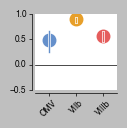

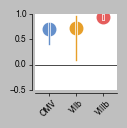

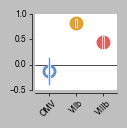

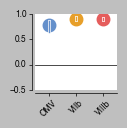

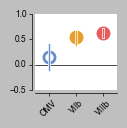

In [112]:
for comp,name in zip([['183_1','183_2'],['181','182']],['across_runs','across_subjects']):
    pl.close('all')

    for param in ['ecc','ang','rfsize','x','y']:
        
        f = pl.figure(figsize=(1.25,1.25))
        s = f.add_subplot(111)
        pl.axhline(0,color='k')


        # eccen-size plot
#         this_roi_comb_order = ['mVIIIb','lVIIIb','VIIb','mOMV','lOMV']

        this_roi_comb_order = ['OMV','VIIb','VIIIb']#VIIIb','lVIIIb','VIIb','mOMV','lOMV']


        for mi,mask in enumerate(this_roi_comb_order):


            # determine this roi mask
            roimask = np.zeros_like(cer_retmaps).astype(bool)
            for subroi in roi_combs[mask]:
                roimask[(cer_retmaps==subroi)] = True

            # determine roi color
            c = get_roi_color(mask)  

            rfsize1 = data[comp[0]][roimask,dims['rfsize']]
            ecc1 = data[comp[0]][roimask,dims['ecc']]
            ang1 = data[comp[0]][roimask,dims['ang']]
            xs1 = np.cos(np.radians(np.ravel(ang1))) * np.ravel(ecc1)
            ys1 = np.sin(np.radians(np.ravel(ang1))) * np.ravel(ecc1)

            rfsize2 = data[comp[1]][roimask,dims['rfsize']]
            ecc2= data[comp[1]][roimask,dims['ecc']]
            ang2 = data[comp[1]][roimask,dims['ang']]

            xs2 = np.cos(np.radians(np.ravel(ang2))) * np.ravel(ecc2)
            ys2 = np.sin(np.radians(np.ravel(ang2))) * np.ravel(ecc2)


            if param == 'x':
                data1 = xs1
                data2 = xs2
                plotrange = [-stim_radius,stim_radius]
            elif param == 'y':
                data1 = ys1
                data2 = ys2
                plotrange = [-stim_radius,stim_radius]

            elif param == 'ecc':
                data1 = ecc1
                data2 = ecc2
                plotrange = [0,stim_radius]

            elif param == 'ang':
                data1 = ang1
                data2 = ang2
                plotrange = [0,360]
                
            elif param == 'rfsize':
                data1 = rfsize1
                data2 = rfsize2
                plotrange = [0,20]


            v = (~np.isnan(data1))*(~np.isnan(data2))

            data1 = data1[v]
            data2 = data2[v]
            
            if param != 'ang':
#                 r,p = sp.stats.pearsonr(data1,data2)
                r,p,l,u = pearsonr_ci(data1,data2)
            else:
                r,(l,u)= pc.corrcc(np.radians(data1),np.radians(data2),ci=0.95,bootstrap_iter=int(1e4))
                
#             pl.plot([mi-0.1,mi+0.1],[r,r],c=c,lw=3)

            if np.arctanh(l) > 0:
                pl.plot(mi,r,'o',ms=8,mec=c,c=c,mew=2)
            else:
                pl.plot(mi,r,'o',ms=8,mec=c,c='w',mew=2)



            pl.plot([mi,mi],[l,u],c='w',lw=2)

            pl.plot([mi,mi],[l,u],c=c,lw=1)

            
            pl.xlim(-0.5,len(this_roi_comb_order)-0.5)  
            pl.ylim(-0.5,1)
            pl.yticks(np.linspace(-0.5,1,4))
#         pl.xticks([0,stim_radius])

        sn.despine(offset=2)

        pl.xticks(range(len(this_roi_comb_order)),this_roi_comb_order,rotation=45)

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'%s_consistency_%s_corrs.pdf'%(name,param)))

# tSNR - R2 correlations

We want to find out if the amount of explained variance in the pRF model is correlated to the temporal signal to noise ratio (tSNR). The tSNR is computed in notebook 5_tSNR by deviding the mean of the signal by the standard deviation. I created these tSNRS for every voxel for every run type (bars, wedges, rings), and than averaged the resulting tSNRs over runs. 

In order to match the unthresholded R2s to the tSNRs, we need the original data, which is saved by subject id (and not subject rank). Therefore, we first need to uncover these ranks again:

In [26]:
def create_roi_mask():
    """
    This mask deselects all voxels outside the retinotopic
    clusters identified in the average subject.
    """
    
    roi_fn = os.path.join(resource_dir,'volume_masks','cerebellum_retmaps.nii')
    maskimg = nb.load(roi_fn)
    roimask = (maskimg.get_data()>0) # valid voxels  

    return roimask

def determine_best_subjects():
    
    """
    This function determines the best subjects based on the median
    r-squared within the retinotopic clusters defined in the average subject.
    """

    roimask = create_roi_mask()

    all_r2 = []
    for sj in range(181):      

        # load the prf results nifti
        fn = os.path.join(data_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii.gz'%sj)
        img = nb.load(fn)
        data = img.get_data()

        # mask r2s with roi mask:
        r2s = np.ravel(data[roimask,dims['r2']])    
        # and get median within these voxels
        all_r2.append(np.nanmedian(r2s))

    # sort subjects based on median r2
    best_subjects = np.argsort(all_r2)[::-1]

    return best_subjects

In [29]:
subids = determine_best_subjects()

In [33]:
# eccen-size plot
this_roi_comb_order = ['all_rois','all_voxels','OMV','VIIb','VIIIb']#VIIIb','lVIIIb','VIIb','mOMV','lOMV']

f = pl.figure(figsize=(2*len(this_roi_comb_order),2))

for mi,mask in enumerate(this_roi_comb_order):

    s = f.add_subplot(1,len(this_roi_comb_order),mi+1)
    pl.title(mask)
    # determine this roi mask
    if mask == 'all_voxels':
        roimask = cer_mask.astype(bool)
    else:
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

    # determine ecc limit and roi color
    c = get_roi_color(mask)  
    
    all_tSNRs = []
    all_r2s = []
    for sj in tqdm(range(181)):
        
        # conver subject rank (sj) back to subject id (si) here:
        si = subids[sj]
        this_sj_data = nb.load(os.path.join(data_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii.gz'%si)).get_data()
        # tsnrs are saved by subject rank, so we can use the rank (sj) here:
        tsnrs = nb.load(os.path.join(data_dir,'timeseries','sub_rank_%d_tsnr_avg_over_tasks.nii'%sj)).get_data()[roimask]
        r2s = this_sj_data[roimask,dims['r2']]

        all_r2s.append(np.nanmedian(r2s))
        all_tSNRs.append(np.nanmedian(tsnrs))
        
    rho,rho_p = sp.stats.spearmanr(np.array(all_tSNRs),np.array(all_r2s))
    r,r_p = sp.stats.pearsonr(np.array(all_tSNRs),np.array(all_r2s))

    sn.regplot(np.array(all_tSNRs),np.array(all_r2s),color=c,label='r: %.2f, p: %.2f\nrho: %.2f, p: %.2f'%(r,r_p,rho,rho_p))
    if mi == 0:
        pl.xlabel('tSNR')
        pl.ylabel('R2')
    pl.xticks([np.min(all_tSNRs),np.max(all_tSNRs)])
    pl.yticks([np.min(all_r2s),np.max(all_r2s)])
    
    pl.legend(loc='best')
    
    sn.despine(offset=2)

pl.tight_layout()
f.savefig(os.path.join(fig_dir,'r2_tsnr_corr.pdf'))


100%|██████████| 181/181 [00:25<00:00,  7.23it/s]


## Timeseries plot

In this plot, we'll get the design matrix from the osf website, and use the pRF model that was fit on all data (wedges / rings / bars) to create a predicted fit for the average of the two bar runs (downloaded in notebook 1_export_ciftis).

In [94]:
# Popeye imports
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.css as css
import scipy as sp
import urllib
import zipfile
import copy

In [102]:
ap_dir = os.path.join(data_dir,'apertures.zip')
ap_url = 'https://osf.io/5sj3m/download'
up_ap_dir = os.path.join(data_dir,'apertures')
mat_dir = os.path.join(data_dir,'RETBARsmall.mat')

### download the design matrices

In [11]:
if not os.path.isfile(ap_dir):
    print('Downloading retinotopy design matrices...')
    urllib.urlretrieve(ap_url, ap_dir)  
    print('downloading done!')
else:
    print('dms already downloaded')

downloading done!


### unpacking the dms

In [12]:
if not os.path.isdir(up_ap_dir):
    print('unpacking dms')
    zip_ref = zipfile.ZipFile(ap_dir, 'r')
    zip_ref.extractall(ap_dir[:-4])
    zip_ref.close()
    # remove zip file
    os.remove(ap_dir)
else:
    print('dms already unpacked')

dms already unpacked


### move and remove files

In [13]:
if not os.path.isfile(mat_dir):
    os.rename(os.path.join(up_ap_dir,'apertures','RETBARsmall.mat'),mat_dir)
    shutil.rmtree(up_ap_dir)
else:
    print('dm ret file already moved')

dm ret file already moved


### now load in file

In [14]:
with h5py.File(mat_dir, 'r') as mat:
    visual_dm = mat['stim'].value.T

### convert file to popey visual stimulus

In [15]:
# Create stimulus design and define model
# ---------------------------------------
stimulus = VisualStimulus(  stim_arr = visual_dm,
                            viewing_distance = 102, 
                            screen_width = 29,
                            scale_factor = 1,
                            tr_length = 1.0,
                            dtype = np.short)

model_func = css.CompressiveSpatialSummationModel(  stimulus = stimulus,
                                                    hrf_model = utils.spm_hrf)
model_func.hrf_delay = 0



### load in the averaged timecourse data

In [40]:
# Get timeseries data
# ---------------------------------------
timeseries_fn = os.path.join(data_dir,'timeseries','avg_prf_timeseries.nii.gz')
timeseries_data = nb.load(timeseries_fn).get_data()

In [41]:
# zscore timeseries
avg = np.nanmean(timeseries_data,axis=-1)[:,:,:,np.newaxis]
std = np.nanstd(timeseries_data,axis=-1)[:,:,:,np.newaxis]
timeseries_data = (timeseries_data-avg)/std

### setup function that creates prediction and rescales

In [26]:
def create_prediction(voxel_idx,roimask):

    # get prf parameters
    ang = np.radians(avgdata[roimask,dims['ang']][voxel_idx])
    ecc = avgdata[roimask,dims['ecc']][voxel_idx]
    size = avgdata[roimask,dims['rfsize']][voxel_idx]

    # get ts data
    these_ts = timeseries_data[roimask]
    
    # convert to cartesian
    x = ecc * np.cos(ang)
    y = ecc * np.sin(ang)

    # this is the n used in the paper
    n = 0.05

    # calculate prediction
    pred = model_func.generate_prediction(x,y,size,n,1,0)
    
    # refit baseline and amp parameters (since fitted on different data)
    dm = np.mat(np.vstack([np.ones_like(pred),pred])).T
    t = these_ts[voxel_idx]
    intercept,slope = np.array(np.linalg.pinv(dm.T * dm) * dm.T * np.mat(t[:,np.newaxis]))     

    # scale prediction
    p =(intercept[0]+pred*slope[0])

    # compute new r2
    r2 = (sp.stats.pearsonr(p,t)[0]**2)*100
    
    return p,r2



### Determine best voxels for these data

In [35]:
these_r2s = {}
ecc_bands = [[0,2],[2,4],[4,6],[6,8]]
for ecc_band in ecc_bands:
    these_r2s[str(ecc_band)] = {}
    
    # select data from this ecc band
    eccs = avgdata[:,:,:,dims['ecc']]
    valid_eccs = (eccs>ecc_band[0])*(eccs<ecc_band[1])
    
    for mi,mask in enumerate(roi_comb_order):
        print('creating predictions for ecc_band %s, mask %s'%(ecc_band,mask))
        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        roimask *= valid_eccs

        # apply mask to timeseries
        these_ts = timeseries_data[roimask]
    
        # now create a prediction for every voxel
        # on the averaged data and save the r2s
        r2s = []
        for v in range(roimask.sum()):

            p,r2 = create_prediction(v,roimask)

            # recompute r2 on this prediction and data
            r2s.append(r2)
            
        these_r2s[str(ecc_band)][mask] = r2s

creating predictions for ecc_band [0, 2], mask mOMV, 0%done
creating predictions for ecc_band [0, 2], mask lOMV, 0%done
creating predictions for ecc_band [0, 2], mask lOMV, 20%done
creating predictions for ecc_band [0, 2], mask lOMV, 40%done
creating predictions for ecc_band [0, 2], mask lOMV, 60%done
creating predictions for ecc_band [0, 2], mask lOMV, 80%done
creating predictions for ecc_band [0, 2], mask VIIb, 0%done
creating predictions for ecc_band [0, 2], mask mVIIIb, 0%done
creating predictions for ecc_band [0, 2], mask mVIIIb, 20%done
creating predictions for ecc_band [0, 2], mask mVIIIb, 40%done
creating predictions for ecc_band [0, 2], mask mVIIIb, 60%done
creating predictions for ecc_band [0, 2], mask mVIIIb, 80%done
creating predictions for ecc_band [0, 2], mask lVIIIb, 0%done
creating predictions for ecc_band [2, 4], mask VIIb, 0%done
creating predictions for ecc_band [2, 4], mask mVIIIb, 0%done
creating predictions for ecc_band [2, 4], mask lVIIIb, 0%done
creating predict

#### now we can create plot for the best voxels

In [65]:
# create plot
# ---------------------------------------
n_vox = 5
for ecc_band in ecc_bands:
    
    # select data from this ecc band
    eccs = avgdata[:,:,:,dims['ecc']]
    valid_eccs = (eccs>ecc_band[0])*(eccs<ecc_band[1])   
    
    for mi,mask in enumerate(roi_comb_order):

        # determine this roi mask
        roimask = np.zeros_like(cer_retmaps).astype(bool)
        for subroi in roi_combs[mask]:
            roimask[(cer_retmaps==subroi)] = True

        roimask *= valid_eccs

        # apply mask to timeseries
        these_ts = timeseries_data[roimask]

        # now determine best voxel based on fits to this data
        r2s = these_r2s[str(ecc_band)][mask]
        best_voxels = np.argsort(r2s)[::-1][:n_vox]

        # and create plots for these voxels
        for best_voxel in best_voxels:

            # get this timeseries
            timeseries = these_ts[best_voxel]

            pred,r2 = create_prediction(best_voxel,roimask)
            
            # generate pRF
            res = 501

            # get pRF parameters for visualization
            ang = np.radians(avgdata[roimask,dims['ang']][best_voxel])
            ecc = avgdata[roimask,dims['ecc']][best_voxel]
            size = avgdata[roimask,dims['rfsize']][best_voxel]
            
            x = ecc * np.cos(ang)
            y = ecc * np.sin(ang)

            f=pl.figure(figsize=(4,1.25))            
            
            # first plot the prf parameters
            s = f.add_subplot(141)
            pl.text(0,0,'ecc: %.2f\nangle: %.2f\nsize: %.2f\nR2: %.2f'%(ecc,ang,size,r2),
                    horizontalalignment='right',verticalalignment='center')            
            pl.xlim(-5,5)
            pl.ylim(-5,5)
            pl.axis('off')
            
        
            # now create a pRF visualization plot
            s = f.add_subplot(142,aspect='equal')

            c = get_roi_color(mask)

            # crosshair
            pl.axhline(0,lw=0.5,color='k')
            pl.axvline(0,lw=0.5,color='k')
            
            # for prf size
            s.add_artist(pl.Circle((x,y),size, color='r',fill=False,alpha=0.25))
            # prf center
            pl.plot(x,y,'o',color='r',ms=3,mec='w',mew=1,alpha=1)

            # plot properties
            pl.xlim(-stim_radius,stim_radius)
            pl.ylim(-stim_radius,stim_radius) 
            pl.xticks([-stim_radius,0,stim_radius])
            pl.yticks([-stim_radius,0,stim_radius])
            pl.xlabel('visual field x (dva)')
            pl.ylabel('visual field y (dva)')
            sn.despine(offset=2)
            
            # and finally the pRF timeseries prediction
            s = f.add_subplot(122)
    
            # timeseries
            pl.plot(timeseries,'o--',color='k',ms=1.5)
            # prediction
            pl.plot(pred,color='r',lw=1.5)

            # this is the gray/white shading to indicate stimulus design
            ylims=s.get_ylim()
            pl.fill_between([0,16],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([16,48],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([48,80],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([80,112],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([112,144],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([144,156],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([156,188],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([188,220],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([220,252],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([252,284],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1) 
            pl.fill_between([284,300],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')             
                
            # plot properties
            sn.despine(offset=2)
            pl.xlabel('time (s)')
            pl.ylabel('BOLD (z-score)')

            # save figure
            pl.tight_layout()
            f.savefig(os.path.join(fig_dir,'pred_%s_eccband_%s_v_%d.pdf'%(mask,ecc_band,best_voxel)))
            